# Exercise 6: Deep Learning

Extension of https://oist.github.io/BrainComputation/Deep.html

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

### 1. NNs and Backprop: Effect of Network Size, Data Size, and Learning Rate on Training

Note that this also covers question two in the exercise.

In [2]:
class ReLU:
    @staticmethod
    def __call__(x): return np.maximum(x, 0)
    @staticmethod
    def prime(x): return (x > 0).astype(float)

class Sigmoid:
    @staticmethod
    def __call__(x): return 1/(1 + np.exp(-x))
    @staticmethod
    def prime(x):
        s = Sigmoid()(x)
        return s * (1 - s)

class Linear:
    @staticmethod
    def __call__(x):
        return x
    @staticmethod
    def prime(x):
        return np.ones_like(x)

class Tanh:
    @staticmethod
    def __call__(x):
        return np.tanh(x)
    @staticmethod
    def prime(x):
        return 1 - np.tanh(x)**2

class Softmax:
    @staticmethod
    def __call__(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class MSE:
    @staticmethod
    def __call__(y_pred, y_true):
        return 0.5 * np.mean((y_pred - y_true)**2)
    @staticmethod
    def delta(y_pred, y_true):
        return (y_pred - y_true)

class CrossEntropy:
    @staticmethod
    def __call__(p_hat, y_true):
        return -np.mean(y_true*np.log(p_hat + 1e-12))
    @staticmethod
    def delta(p_hat, y_true):
        # assuming p_hat is the output of softmax and y_true is one-hot encoded
        return (p_hat - y_true)

In [3]:
class Network:
    def __init__(self, layer_sizes, layer_activations):
        assert len(layer_activations) == len(layer_sizes)-1
        self.sizes   = layer_sizes
        self.thetas  = layer_activations

        # xavier init scheme
        self.biases  = [np.zeros((1, n)) for n in layer_sizes[1:]] # row-vecs
        self.weights = []
        for m, n in zip(layer_sizes[:-1], layer_sizes[1:]):
            limit = np.sqrt(6 / (m + n))
            self.weights.append(np.random.uniform(-limit, limit, size=(m, n)))

    def fwd_prop(self, X):
        X_ell = X # X_0 (input layer)
        for W, b, theta in zip(self.weights, self.biases, self.thetas):
            X_ell = theta((X_ell @ W) + b) # compute X_l, 0 < l <= L
        return X_ell # X_L (output layer)

    def back_prop(self, X, ys, loss):
        # we can not support vector activation functions (like softmax) in 
        # middle layers (and at the input)
        for i in range(len(self.thetas)-1):
            assert not isinstance(self.thetas[i], Softmax)

        # get summations and activations
        X_ells = [X]
        S_ells = []
        for W, b, theta in zip(self.weights, self.biases, self.thetas):
            S_ell = (X_ells[-1] @ W) + b
            X_ells.append(theta(S_ell))
            S_ells.append(S_ell)

        # create list of gradients (intended to be used in increasing order of layers)
        grad_biases  = len(self.biases)*[None]
        grad_weights = len(self.weights)*[None]

        # backprop: start from ell = L
        if isinstance(loss, CrossEntropy) and isinstance(self.thetas[-1], Softmax):
            delta_ell = loss.delta(X_ells[-1], ys)
        elif not isinstance(loss, CrossEntropy) and not isinstance(self.thetas[-1], Softmax):
            delta_ell = loss.delta(X_ells[-1], ys) * self.thetas[-1].prime(S_ells[-1])
        else:
            raise ValueError("Unsupported loss function")
        grad_biases[-1]  = delta_ell.sum(axis=0)
        grad_weights[-1] = X_ells[-2].T @ delta_ell

        # continue backwards (1 < ell < L)
        for l in range(2, len(self.sizes)):
            delta_ell = delta_ell @ self.weights[-l+1].T * self.thetas[-l].prime(S_ells[-l])
            grad_biases[-l]  = delta_ell.sum(axis=0)
            grad_weights[-l] = X_ells[-l-1].T @ delta_ell

        return grad_weights, grad_biases
    
    def apply_gradients(self, grad_weights, grad_biases, alpha):
        self.biases  = [W - alpha*delW for W, delW in zip(self.biases, grad_biases)]
        self.weights = [W - alpha*delW for W, delW in zip(self.weights, grad_weights)]

    def train(self, Xs, Ys, loss, epochs, alpha=0.1):
        loss_hist = []
        self.alpha = alpha

        for epoch in range(epochs):
            # apply gradient descent
            grad_weights, grad_biases = self.back_prop(Xs, Ys, loss)
            grad_weights = [gw / Xs.shape[0] for gw in grad_weights]
            grad_biases = [gb / Xs.shape[0] for gb in grad_biases]
            self.apply_gradients(grad_weights, grad_biases, alpha)

            # compute current loss
            loss_hist.append(loss(self.fwd_prop(Xs), Ys))

            # print progress
            if epoch % (epochs//10) == 0 or epoch == 1 or epoch == epochs-1:
                print(f"Epoch {epoch} | Training Loss: {loss_hist[-1]}")

        return self.weights, self.biases, loss_hist

Epoch 0 | Training Loss: 0.3210240966677601
Epoch 1 | Training Loss: 0.2603446190110549
Epoch 100 | Training Loss: 0.19919136087692216
Epoch 200 | Training Loss: 0.10756724441112954
Epoch 300 | Training Loss: 0.056716515220982214
Epoch 400 | Training Loss: 0.0375608300052449
Epoch 500 | Training Loss: 0.02934495619423895
Epoch 600 | Training Loss: 0.025191180321962926
Epoch 700 | Training Loss: 0.022808898024319593
Epoch 800 | Training Loss: 0.021308678853840846
Epoch 900 | Training Loss: 0.020293913168798753
Epoch 999 | Training Loss: 0.019573626622308857


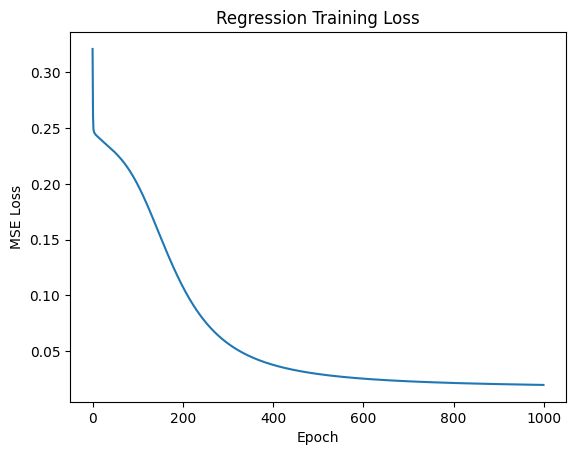

In [4]:
N = 200
X_reg = np.random.uniform(-6,6,(N,1))
Y_reg = np.sin(X_reg)
nn_reg = Network([1, 20, 1], [Sigmoid(), Tanh()])
_, _, loss_reg = nn_reg.train(X_reg, Y_reg, MSE(), epochs=1000, alpha=2e-1)
plt.figure()
plt.plot(loss_reg)
plt.title("Regression Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.show()

Epoch 0 | Training Loss: 0.2312980401133625
Epoch 1 | Training Loss: 0.22451876513198613
Epoch 100 | Training Loss: 0.033543120359782554
Epoch 200 | Training Loss: 0.01891408016277219
Epoch 300 | Training Loss: 0.014107808606408735
Epoch 400 | Training Loss: 0.011549190071536724
Epoch 500 | Training Loss: 0.009880560160199328
Epoch 600 | Training Loss: 0.008671797369046611
Epoch 700 | Training Loss: 0.0077297113725053514
Epoch 800 | Training Loss: 0.00695689391939491
Epoch 900 | Training Loss: 0.006319517274944899
Epoch 999 | Training Loss: 0.005790807608118311


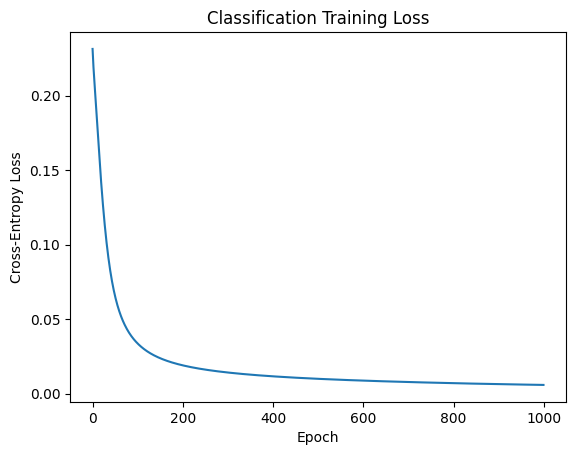

In [5]:
digits = load_digits()
Xc = digits.data / 16.0
y = digits.target.reshape(-1,1)
enc = OneHotEncoder(sparse_output=False)
Yc = enc.fit_transform(y)
nn_clf = Network([64, 32, 10], [ReLU(), Softmax()])
_, _, loss_clf = nn_clf.train(Xc, Yc, CrossEntropy(), epochs=1000, alpha=2e-1)
plt.figure()
plt.plot(loss_clf)
plt.title("Classification Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

In [ ]:
def run_regression_experiments(units_list, data_sizes, lrs, epochs=1000, repeats=5):
    results = {}
    for lr in lrs:
        hu_vals, ds_vals, avg_losses = [], [], []
        for hu in units_list:
            for ds in data_sizes:
                # generate dataset once per config
                X = np.random.uniform(-6, 6, (ds,1))
                Y = np.sin(X)
                # run multiple initializations
                rep_losses = []
                for _ in range(repeats): # diff nets but same data
                    nn = Network([1, hu, 1], [Sigmoid(), Tanh()])
                    _, _, hist = nn.train(X, Y, MSE(), epochs, alpha=lr)
                    rep_losses.append(np.mean(hist[-10:]))
                # record average loss
                hu_vals.append(hu)
                ds_vals.append(ds)
                avg_losses.append(np.mean(rep_losses))
        results[lr] = (np.array(hu_vals), np.array(ds_vals), np.array(avg_losses))
    return results

def run_classification_experiments(units_list, fracs, lrs, epochs=1000, repeats=5):
    results = {}
    digits = load_digits()
    Xc = digits.data / 16.0
    y = digits.target.reshape(-1,1)
    enc = OneHotEncoder(sparse_output=False)
    Yc = enc.fit_transform(y)
    N = Xc.shape[0]
    for lr in lrs:
        hu_vals, frac_vals, avg_losses = [], [], []
        for hu in units_list:
            for frac in fracs:
                n = int(N * frac)
                rep_losses = []
                for _ in range(repeats): # diff nets and diff data
                    indices = np.random.permutation(N)
                    Xc_shuffled = Xc[indices]
                    Yc_shuffled = Yc[indices]
                    nn = Network([64, hu, 10], [ReLU(), Softmax()])
                    _, _, hist = nn.train(Xc_shuffled[:n], Yc_shuffled[:n], CrossEntropy(), epochs, alpha=lr)
                    rep_losses.append(np.mean(hist[-10:]))
                hu_vals.append(hu)
                frac_vals.append(frac * N)
                avg_losses.append(np.mean(rep_losses))
        results[lr] = (np.array(hu_vals), np.array(frac_vals), np.array(avg_losses))
    return results

units_list = range(2, 21, 2)  # hidden units
data_sizes = range(50, 1051, 100) # data samples
lrs = [2.5e-3, 2.5e-2, 0.25, 1.0] # learning rates
reg_params = run_regression_experiments(units_list, data_sizes, lrs, epochs=1500)
data_splits = [0.25, 0.5, 0.75, 1.0]
clf_params = run_classification_experiments(units_list, data_splits, lrs, epochs=1500)

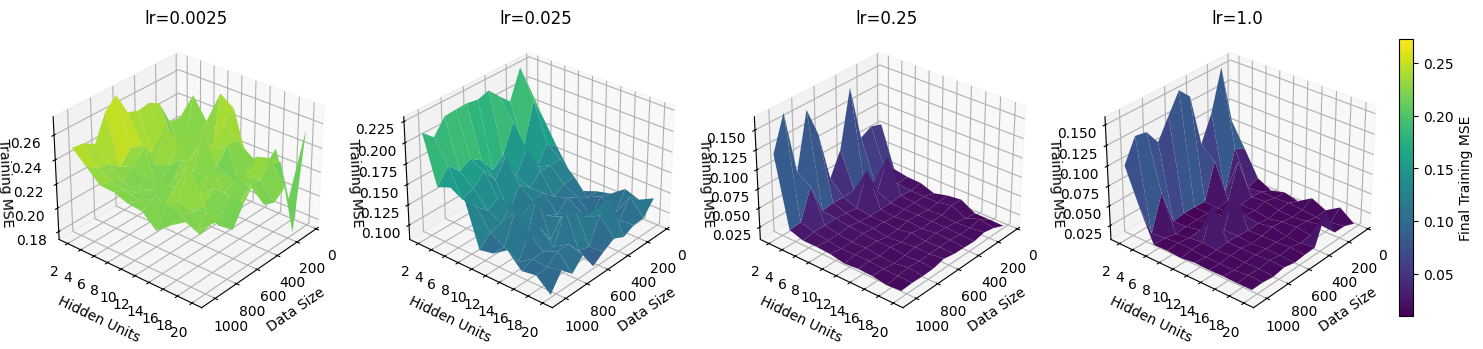

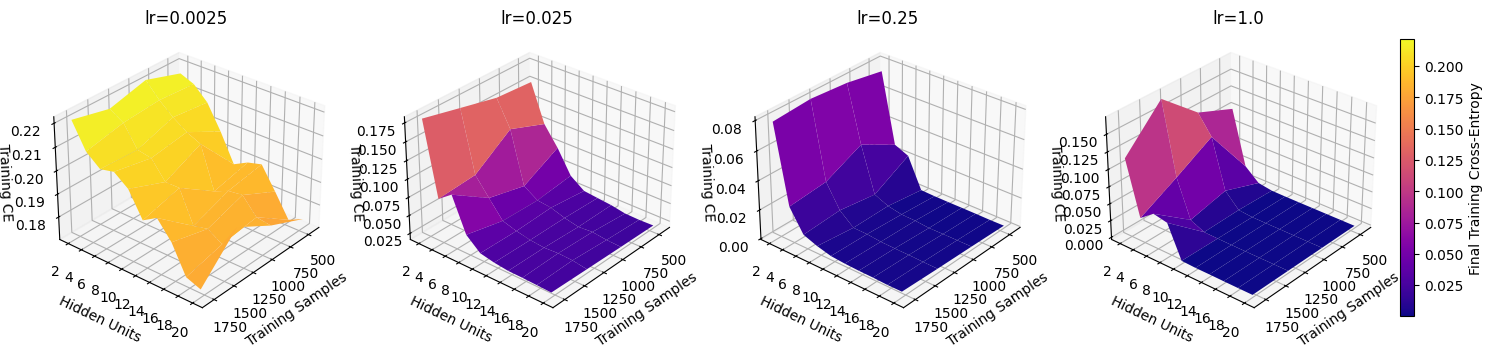

In [42]:
# regression panel
lrs = list(reg_params.keys())
all_losses = np.concatenate([vals[2] for vals in reg_params.values()])
vmin, vmax = all_losses.min(), all_losses.max()
fig, axes = plt.subplots(1, len(lrs), subplot_kw={'projection': '3d'}, figsize=(5 * len(lrs), 6),
    constrained_layout=False
)
fig.subplots_adjust(left=0.1, wspace=0.2)
for ax, lr in zip(axes, lrs):
    hu, ds, loss = reg_params[lr]
    Z = loss.reshape(len(units_list), len(data_sizes))
    X, Y = np.meshgrid(data_sizes, units_list)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', vmin=vmin, vmax=vmax, edgecolor='none')
    ax.view_init(elev=30, azim=40)
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Data Size')
    ax.set_ylabel('Hidden Units')
    ax.set_zlabel('Training MSE', labelpad=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig.colorbar(surf, ax=axes, shrink=0.6, aspect=20, pad=0.01, label='Final Training MSE')
plt.show()

# classification panel
lrs_clf = list(clf_params.keys())
all_clf_losses = np.concatenate([vals[2] for vals in clf_params.values()])
vmin_c, vmax_c = all_clf_losses.min(), all_clf_losses.max()
ds_vals = np.array(data_splits) * Xc.shape[0]
fig, axes = plt.subplots(1, len(lrs_clf), subplot_kw={'projection': '3d'}, figsize=(5 * len(lrs_clf), 6),
    constrained_layout=False
)
fig.subplots_adjust(left=0.1, wspace=0.2)
for ax, lr in zip(axes, lrs_clf):
    hu, ds, loss = clf_params[lr]
    Z = loss.reshape(len(units_list), len(data_splits))
    X, Y = np.meshgrid(ds_vals, units_list)
    surf = ax.plot_surface(X, Y, Z, cmap='plasma', vmin=vmin_c, vmax=vmax_c, edgecolor='none')
    ax.view_init(elev=30, azim=40)
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('Hidden Units')
    ax.set_zlabel('Training CE', labelpad=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig.colorbar(surf, ax=axes, shrink=0.6, aspect=20, pad=0.01, label='Final Training Cross-Entropy')
plt.show()

In [ ]:
def run_regression_experiments(depth_list, data_sizes, lrs, epochs=1000, repeats=5):
    results = {}
    for lr in lrs:
        depth_vals, ds_vals, avg_losses = [], [], []
        for depth in depth_list:
            for ds in data_sizes:
                # generate dataset once per config
                X = np.random.uniform(-6, 6, (ds,1))
                Y = np.sin(X)
                # run multiple initializations
                rep_losses = []
                for _ in range(repeats): # diff nets but same data
                    layers = [1] + [10]*depth + [1]
                    activations = [Sigmoid()]*depth + [Tanh()]
                    nn = Network(layers, activations)
                    _, _, hist = nn.train(X, Y, MSE(), epochs, alpha=lr)
                    rep_losses.append(np.mean(hist[-10:]))
                # record average loss
                depth_vals.append(hu)
                ds_vals.append(ds)
                avg_losses.append(np.mean(rep_losses))
        results[lr] = (np.array(depth_vals), np.array(ds_vals), np.array(avg_losses))
    return results

def run_classification_experiments(depth_list, fracs, lrs, epochs=1000, repeats=5):
    results = {}
    digits = load_digits()
    Xc = digits.data / 16.0
    y = digits.target.reshape(-1,1)
    enc = OneHotEncoder(sparse_output=False)
    Yc = enc.fit_transform(y)
    N = Xc.shape[0]
    for lr in lrs:
        depth_vals, frac_vals, avg_losses = [], [], []
        for depth in depth_list:
            for frac in fracs:
                n = int(N * frac)
                rep_losses = []
                for _ in range(repeats): # diff nets and diff data
                    indices = np.random.permutation(N)
                    Xc_shuffled = Xc[indices]
                    Yc_shuffled = Yc[indices]
                    layers = [64] + [10]*depth + [10]
                    activations = [ReLU()]*depth + [Softmax()]
                    nn = Network(layers, activations)
                    _, _, hist = nn.train(Xc_shuffled[:n], Yc_shuffled[:n], CrossEntropy(), epochs, alpha=lr)
                    rep_losses.append(np.mean(hist[-10:]))
                depth_vals.append(hu)
                frac_vals.append(frac * N)
                avg_losses.append(np.mean(rep_losses))
        results[lr] = (np.array(depth_vals), np.array(frac_vals), np.array(avg_losses))
    return results

depth_list = [1, 2, 3, 4]
data_sizes = range(50, 1001, 100)
data_splits = [0.25, 0.5, 0.75, 1.0]
lrs = [2.5e-3, 2.5e-2, 0.25, 1.0]
reg_params = run_regression_experiments(depth_list, data_sizes, lrs, epochs=1500)
clf_params = run_classification_experiments(depth_list, data_splits, lrs, epochs=1500)

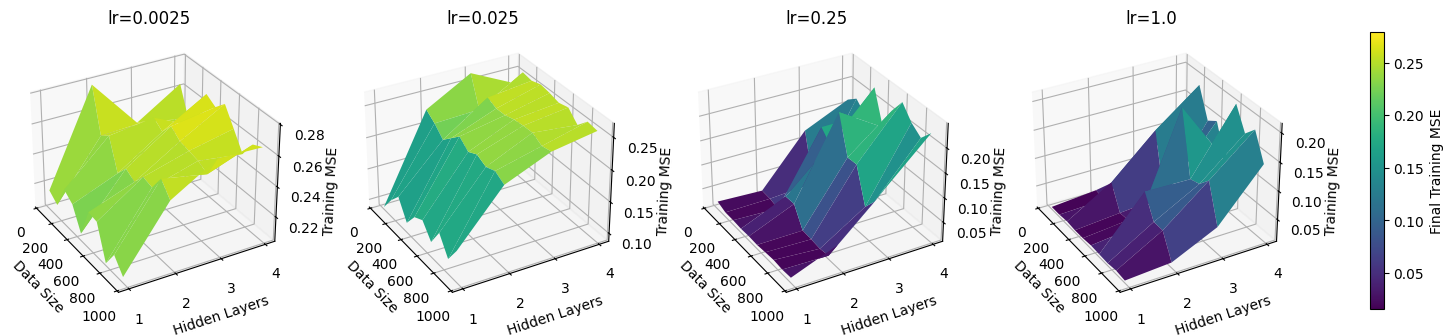

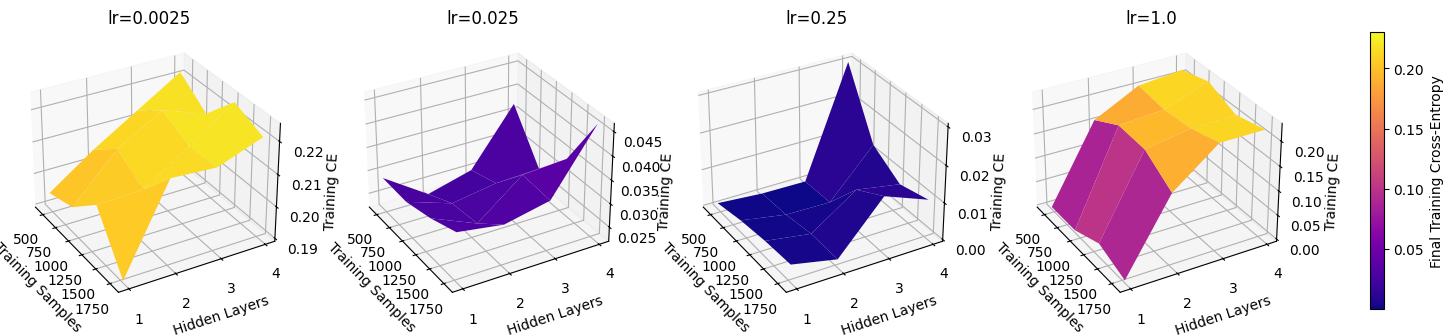

In [51]:
# regression panel
lrs = list(reg_params.keys())
all_losses = np.concatenate([vals[2] for vals in reg_params.values()])
vmin, vmax = all_losses.min(), all_losses.max()
fig, axes = plt.subplots(1, len(lrs), subplot_kw={'projection': '3d'}, figsize=(5 * len(lrs), 6),
    constrained_layout=False
)
fig.subplots_adjust(left=0.1, wspace=0.2)
for ax, lr in zip(axes, lrs):
    depths, ds, loss = reg_params[lr]
    Z = loss.reshape(len(depth_list), len(data_sizes))
    X, Y = np.meshgrid(data_sizes, depth_list)
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', vmin=vmin, vmax=vmax, edgecolor='none')
    ax.view_init(elev=30, azim=-30)
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Data Size')
    ax.set_ylabel('Hidden Layers')
    ax.set_zlabel('Training MSE', labelpad=1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig.colorbar(surf, ax=axes, shrink=0.6, aspect=20, pad=0.05, label='Final Training MSE')
plt.show()

# classification panel
lrs_clf = list(clf_params.keys())
all_clf_losses = np.concatenate([vals[2] for vals in clf_params.values()])
vmin_c, vmax_c = all_clf_losses.min(), all_clf_losses.max()
ds_vals = np.array(data_splits) * Xc.shape[0]
fig, axes = plt.subplots(1, len(lrs_clf), subplot_kw={'projection': '3d'}, figsize=(5 * len(lrs_clf), 6),
    constrained_layout=False
)
fig.subplots_adjust(left=0.1, wspace=0.2)
for ax, lr in zip(axes, lrs_clf):
    depths, ds, loss = clf_params[lr]
    Z = loss.reshape(len(depth_list), len(data_splits))
    X, Y = np.meshgrid(ds_vals, depth_list)
    surf = ax.plot_surface(X, Y, Z, cmap='plasma', vmin=vmin_c, vmax=vmax_c, edgecolor='none')
    ax.view_init(elev=30, azim=-30)
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('Hidden Layers')
    ax.set_zlabel('Training CE', labelpad=1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig.colorbar(surf, ax=axes, shrink=0.6, aspect=20, pad=0.05, label='Final Training Cross-Entropy')
plt.show()

As can be seen from the 2 sets of plots above (with varying hidden units in one layer versus varying network depth), a moderate value of learning rate generally produces good fits and stable results over the same number of training epochs, and that more data helps in achieving lower loss values when the learning rate is low. Moreover, more hidden units in one layer achieve lower error due to higher expressivity of the network; however, more layers require longer training and usually produce lower quality fits over the same number of epochs. Note that here we only show results from training error, and it is predictable that lower training data size will result in higher test (or validation) error.

### 2. Restricted Boltzmann Machines: Varying Hidden Units and CD-K

In [67]:
class RBM:
    def __init__(self, Mv, Mh, winit=0.1):
        self.Mv, self.Mh = Mv, Mh
        self.W = np.random.normal(scale=winit, size=(Mv, Mh))
        self.b = np.zeros(Mv)
        self.c = np.zeros(Mh)

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def phv(self, v):
        return self.sigmoid(self.c + v @ self.W)

    def pvh(self, h):
        return self.sigmoid(self.b + self.W @ h)

    def sample(self, v0, K):
        vk = v0.copy()
        for _ in range(K):
            hk = (np.random.rand(self.Mh) < self.phv(vk)).astype(float)
            vk = (np.random.rand(self.Mv) < self.pvh(hk)).astype(float)
        return vk, hk

    def train(self, V, K=1, alpha=0.01, T=100):
        N = V.shape[0]
        mse = np.zeros(T)
        for t in range(T):
            errors = []
            for n in np.random.permutation(N):
                v0 = V[n]
                h0 = (np.random.rand(self.Mh) < self.phv(v0)).astype(float)
                vk, hk = self.sample(v0, K)
                # weight and bias updates
                self.W += alpha * (np.outer(v0, h0) - np.outer(vk, hk))
                self.b += alpha * (v0 - vk)
                self.c += alpha * (h0 - hk)
                errors.append(((v0 - vk)**2).sum())
            mse[t] = np.mean(errors)
        return mse

def imgrid(x, Nh=None):
    """x: N*Pv*Ph image array"""
    N, Pv, Ph = x.shape
    if Nh == None:
        Nh = (int)(np.ceil(np.sqrt(N)/10)*10) if N>10 else N
    Nv = (int)(np.ceil(N/Nh)) # rows
    if N < Nv*Nh: # pad by zeros
        x = np.vstack((x, np.zeros((Nv*Nh-N,Pv,Ph))))
    x = x.reshape((Nv,Nh,Pv,Ph))
    x = np.transpose(x, (0,2,1,3))
    x = x.reshape((Nv*Pv, Nh*Ph))
    plt.imshow(x, extent=(0,Nh,Nv,0))

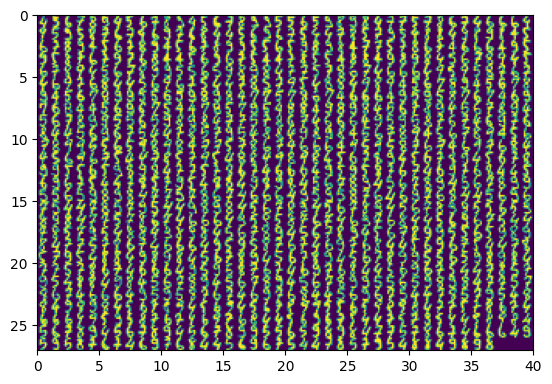

In [68]:
# select only 4-9
digits = load_digits()
mask = (digits.target > 3) & (digits.target < 10)
X = digits.data[mask] / digits.data.max()
imgrid(X.reshape((-1,8,8)))

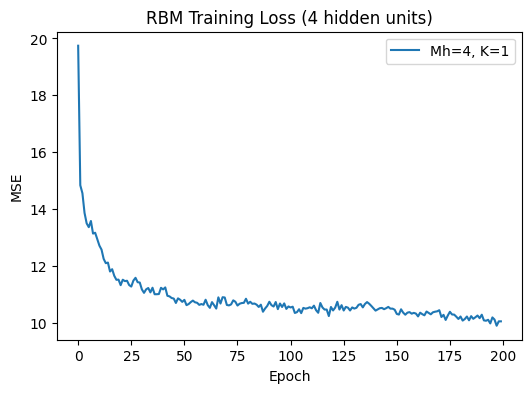

In [105]:
# sample training
V_train = X[:500]  # first 500 samples
rbm_small = RBM(Mv=8*8, Mh=4, winit=0.1) # Mh=4, K=1
mse_hist = rbm_small.train(V_train, K=1, alpha=0.01, T=200)
plt.figure(figsize=(6,4))
plt.plot(mse_hist, label='Mh=4, K=1')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('RBM Training Loss (4 hidden units)')
plt.legend()
plt.show()

In [106]:
# experiment params
Mv = 8 * 8
N_train = 1000
V_train = X[:N_train]
V_test  = X[N_train:]
units = [5, 10, 15, 20]
Ks = [1, 3, 5, 8]
alpha = 0.01
T = 200

# run fits/training with repeats
repeats = 5
avg_mse = np.zeros((len(units), len(Ks)))
for i, Mh in enumerate(units):
    for j, K in enumerate(Ks):
        rep_err = []
        for _ in range(repeats):
            rbm = RBM(Mv, Mh, winit=0.1)
            rbm.train(V_train, K=K, alpha=alpha, T=T)
            test_err = [np.sum((v0 - rbm.sample(v0, K)[0])**2) for v0 in V_test]
            rep_err.append(np.mean(test_err))
        avg_mse[i, j] = np.mean(rep_err)

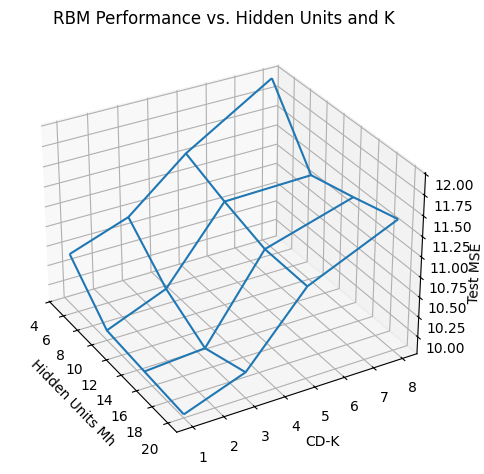

In [110]:
# result
U, K = np.meshgrid(Ks, units)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=-30)
wire = ax.plot_wireframe(K, U, avg_mse, rcount=4, ccount=4)
ax.set_xlabel('Hidden Units Mh')
ax.set_ylabel('CD-K')
ax.set_zlabel('Test MSE', labelpad=1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('RBM Performance vs. Hidden Units and K')
plt.tight_layout()
plt.show()

As can be seen, K=1 generally produces the best result or at least a good fit, and a higher number of hidden units helps store and reconstruct patterns better.